In [2]:
import tensorflow as tf
print(len(tf.config.list_physical_devices('GPU'))>0)

True


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator # For data augmentation

from keras.applications import VGG16, ResNet101
from keras.layers import *
from keras.models import Model
from keras.utils import plot_model

%matplotlib inline

In [4]:
folder_path = 'C:/Users/rsk13/Desktop/Om/DL/Functional API/archive/UTKFace'

In [5]:
age, gender, image_path = [], [], []

for file in os.listdir(folder_path):
    age.append(int(file.split('_')[0]))
    gender.append(int(file.split('_')[1]))
    image_path.append(file)

In [6]:
len(age), len(gender), len(image_path)

(23708, 23708, 23708)

### Creating a dataframe

In [7]:
df = pd.DataFrame({'Age':age, 'Gender':gender, 'Image':image_path})
df.head()

,Age,Gender,Image
0,100,0,100_0_0_20170112213500903.jpg.chip.jpg
1,100,0,100_0_0_20170112215240346.jpg.chip.jpg
2,100,1,100_1_0_20170110183726390.jpg.chip.jpg
3,100,1,100_1_0_20170112213001988.jpg.chip.jpg
4,100,1,100_1_0_20170112213303693.jpg.chip.jpg


In [8]:
df['Age'].value_counts()

Age
26     2197
1      1123
28      918
35      880
24      859
       ... 
115       3
91        2
101       2
103       1
111       1
Name: count, Length: 104, dtype: int64

In [9]:
df.shape

(23708, 3)

### Splitting Data to train and test

In [10]:
train_data = df.sample(frac=1, random_state=0).iloc[:20000]
test_data = df.sample(frac=1, random_state=0).iloc[20000:]

In [11]:
train_data.shape, test_data.shape

((20000, 3), (3708, 3))

### Data Augmentation

In [14]:
train = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,    
    rescale=1/255,
)

test = ImageDataGenerator(rescale=1./255)

In [15]:
train_generator = train.flow_from_dataframe(train_data,
                                            directory=folder_path,
                                            x_col='Image',
                                            y_col=['Age','Gender'],
                                            target_size=(200,200),
                                            class_mode='multi_output')

test_generator = test.flow_from_dataframe(test_data,
                                            directory=folder_path,
                                            x_col='Image',
                                            y_col=['Age','Gender'],
                                            target_size=(200,200),
                                          class_mode='multi_output')

Found 20000 validated image filenames.
Found 3708 validated image filenames.


## Model Building

In [16]:
res = ResNet101(include_top=False, input_shape=(200,200,3))

171446536/171446536 [==============================] - 68s 0us/step


In [17]:
# setting initial layers training
res.trainable = False

In [18]:
output = res.layers[-1].output # Copying the last layer of VGG16 output (maxpool) to 'output'

In [19]:
flatten = Flatten()(output)

Dense1 = Dense(512, activation='relu')(flatten) #Age
Dense2 = Dense(512, activation='relu')(flatten) #Gender

Dense3 = Dense(512, activation='relu')(Dense1) #Age
Dense4 = Dense(512, activation='relu')(Dense2) #Gender
 
output1 = Dense(1, activation='linear', name='Age')(Dense3) # only naming the layers
output2 = Dense(1, activation='sigmoid', name='Gender')(Dense4) # we are not passing column names

In [20]:
model = Model(inputs = res.input, outputs = [output1, output2])

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 50, 50, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 50, 50, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 50, 50, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 50, 50, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 25, 25, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 25, 25, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 25, 25, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 25, 25, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 13, 13, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 13, 13, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 13, 13, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 13, 13, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 13, 13, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 13, 13, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 13, 13, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 13, 13, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block8_1_conv (Conv2D)   (None, 13, 13, 256)  262400      ['conv4_block7_out[0][0]']       
                                                                                                  
 conv4_block8_1_bn (BatchNormal  (None, 13, 13, 256)  1024       ['conv4_block8_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block8_1_relu (Activatio  (None, 13, 13, 256)  0          ['conv4_block8_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block8_2_conv (Conv2D)   (None, 13, 13, 256)  590080      ['conv4_block8_1_relu[0][0]']    
          

                                )                                                                 
                                                                                                  
 conv4_block11_1_conv (Conv2D)  (None, 13, 13, 256)  262400      ['conv4_block10_out[0][0]']      
                                                                                                  
 conv4_block11_1_bn (BatchNorma  (None, 13, 13, 256)  1024       ['conv4_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block11_1_relu (Activati  (None, 13, 13, 256)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block13_out (Activation)  (None, 13, 13, 1024  0          ['conv4_block13_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv4_block14_1_conv (Conv2D)  (None, 13, 13, 256)  262400      ['conv4_block13_out[0][0]']      
                                                                                                  
 conv4_block14_1_bn (BatchNorma  (None, 13, 13, 256)  1024       ['conv4_block14_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block14_1_relu (Activati  (None, 13, 13, 256)  0          ['conv4_block14_1_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block16_out (Activation)  (None, 13, 13, 1024  0          ['conv4_block16_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv4_block17_1_conv (Conv2D)  (None, 13, 13, 256)  262400      ['conv4_block16_out[0][0]']      
                                                                                                  
 conv4_block17_1_bn (BatchNorma  (None, 13, 13, 256)  1024       ['conv4_block17_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block17_1_relu (Activati  (None, 13, 13, 256)  0          ['conv4_block17_1_bn[0][0]']     
 on)      

                                )                                 'conv4_block19_3_bn[0][0]']     
                                                                                                  
 conv4_block19_out (Activation)  (None, 13, 13, 1024  0          ['conv4_block19_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv4_block20_1_conv (Conv2D)  (None, 13, 13, 256)  262400      ['conv4_block19_out[0][0]']      
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 13, 13, 256)  1024       ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block22_add (Add)        (None, 13, 13, 1024  0           ['conv4_block21_out[0][0]',      
                                )                                 'conv4_block22_3_bn[0][0]']     
                                                                                                  
 conv4_block22_out (Activation)  (None, 13, 13, 1024  0          ['conv4_block22_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv4_block23_1_conv (Conv2D)  (None, 13, 13, 256)  262400      ['conv4_block22_out[0][0]']      
                                                                                                  
 conv4_block23_1_bn (BatchNorma  (None, 13, 13, 256)  1024       ['conv4_block23_1_conv[0][0]']   
 lization)                                                                                        
          

 conv5_block2_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_block2_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block2_add[0][0]']       
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block2_out[0][0]']       
                                                                                                  
 conv5_blo

In [22]:
plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


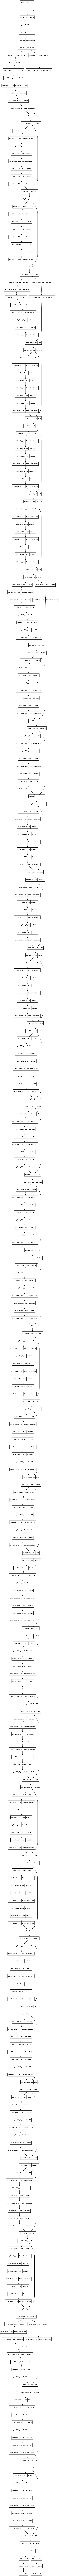

In [23]:
model.compile(optimizer='adam',loss={'Age':'mae','Gender':'binary_crossentropy'}, 
              metrics={'Age':'mae','Gender':'Accuracy'})

In [24]:
history = model.fit(train_generator, validation_data=test_generator, batch_size=32, epochs=10)

Epoch 1/10
625/625 [==============================] - 365s 548ms/step - loss: 16.6912 - Age_loss: 15.7025 - Gender_loss: 0.9888 - Age_mae: 15.7025 - Gender_Accuracy: 0.5181 - val_loss: 16.4495 - val_Age_loss: 15.7569 - val_Gender_loss: 0.6927 - val_Age_mae: 15.7569 - val_Gender_Accuracy: 0.5173
Epoch 2/10
625/625 [==============================] - 199s 319ms/step - loss: 15.6056 - Age_loss: 14.9088 - Gender_loss: 0.6969 - Age_mae: 14.9088 - Gender_Accuracy: 0.5235 - val_loss: 15.2319 - val_Age_loss: 14.5390 - val_Gender_loss: 0.6930 - val_Age_mae: 14.5390 - val_Gender_Accuracy: 0.5173
Epoch 3/10
625/625 [==============================] - 235s 376ms/step - loss: 15.4635 - Age_loss: 14.7671 - Gender_loss: 0.6964 - Age_mae: 14.7671 - Gender_Accuracy: 0.5234 - val_loss: 15.4501 - val_Age_loss: 14.7574 - val_Gender_loss: 0.6927 - val_Age_mae: 14.7574 - val_Gender_Accuracy: 0.5173
Epoch 4/10
625/625 [==============================] - 214s 343ms/step - loss: 15.3115 - Age_loss: 14.6144 - Gend

In [25]:
history.history.keys()

dict_keys(['loss', 'Age_loss', 'Gender_loss', 'Age_mae', 'Gender_Accuracy', 'val_loss', 'val_Age_loss', 'val_Gender_loss', 'val_Age_mae', 'val_Gender_Accuracy'])

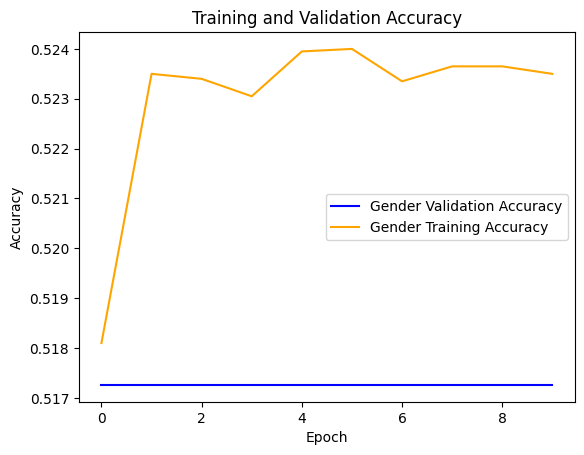

In [26]:
plt.plot(history.history['val_Gender_Accuracy'], color='blue', label='Gender Validation Accuracy')
plt.plot(history.history['Gender_Accuracy'], color='orange', label='Gender Training Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.legend()

plt.show()

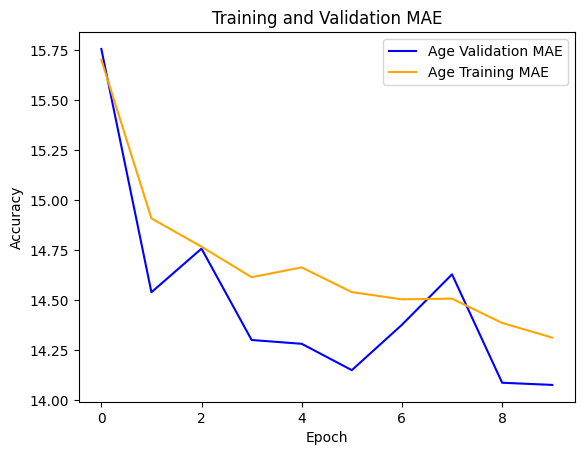

In [27]:
plt.plot(history.history['val_Age_mae'], color='blue', label='Age Validation MAE')
plt.plot(history.history['Age_mae'], color='orange', label='Age Training MAE')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation MAE')

plt.legend()

plt.show()